In [1]:
%run ../../python-seminar/DataFiles_and_Notebooks/talktools.py

# Statistical Learning and Prediction

<img src="http://en.proft.me/media/science/ml_svlw.jpg">

### Machine Learning with scikit-learn

Make sure you have version >= 0.19 installed

```
conda update scikit-learn -y
# or...
# pip install scikit-learn
```

See https://scikit-learn.org/stable/

also: also: `mlpy`, `orange`, `keras`, `nolearn`, `tensorflow`, `astroML`, … 

In [2]:
import sklearn
sklearn.__version__

'1.0.2'

<img src="http://1.bp.blogspot.com/-ME24ePzpzIM/UQLWTwurfXI/AAAAAAAAANw/W3EETIroA80/s1600/drop_shadows_background.png">

## Supervised Learning: Regression

Use training set of $(\vec x,y)$ pairs to learn to predict $y$ for new $\vec x$. **Regression** is predicting a *continuous* outcome ($y$) variable from a vector of input features ($\vec x$). That is, we seek to learn:

$f(\vec x) = y$

 In "theory-driven" MCMC modeling, we already think we know from physics what the functional form of $f$ is and what we try to do is figure out the parameters of $f$ that best accommodate the data we have and the beliefs we start with. When we do not know a functional form for $f$ we take more "data driven" approach, such as with Gaussian Processes.

In `sklearn` there are a lot of "data driven" modelling possibilities.

- Linear Regression:  `linear_model.LinearRegression`
- Lasso & Ridge Reg.:  `linear_model.Lasso` / `linear_model.Ridge`
- Gaussian Process Regression: `gaussian_process.GaussianProcess`
- Nearest Neighbor Regression:  `neighbors.KNeighborsRegressor`
- Support Vector Regression:   `svm.SVR`
- Regression Trees:  `tree.DecisionTreeRegressor`

An aside on the "data driven" vs "theory driven" distinction...

## Regression ## 

Let's take a look at the famous Boston Housing data. We don't have a good physics model for this (of course there are economic theories...). for now we just have data and seek a data-driven model.

In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm

import seaborn as sns
sns.set_context("talk")

%matplotlib inline
import joblib

#import joblib
#sys.modules['sklearn.externals.joblib'] = joblib
from sklearn import datasets
import pandas as pd

In [4]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X.columns.values

array(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude'], dtype=object)

In [5]:
from sklearn.datasets import fetch_california_housing
df, y = fetch_california_housing(return_X_y=True, as_frame=True)

df["target"]  = y
nbins = 5
df["target_binned"] = pd.qcut(df["target"], nbins, labels=False)
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target,target_binned
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,4
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,4
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,4
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,4
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,4
...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781,0
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771,0
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923,0
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847,0


In [6]:
print("feature vector shape=", X.shape)
print("output shape=", y.shape)
feature_names = X.columns.values
print(feature_names)

feature vector shape= (20640, 8)
output shape= (20640,)
['MedInc' 'HouseAge' 'AveRooms' 'AveBedrms' 'Population' 'AveOccup'
 'Latitude' 'Longitude']


Let's plot some data (Y axis is what we want to predict)

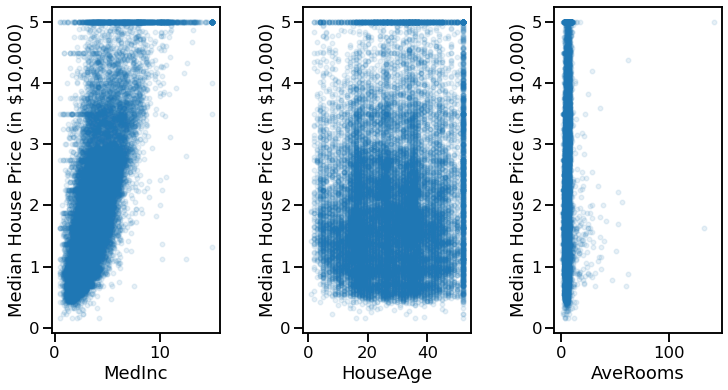

In [7]:
f, axs = plt.subplots(1, 3, figsize=(12,6))

for i, ax in enumerate(axs):
    ax.scatter(X[feature_names[i]], y, alpha=0.1, marker=".",
               edgecolor=None)
    ax.set_xlabel(feature_names[i])
    ax.set_ylabel("Median House Price (in $10,000)")
    
plt.subplots_adjust(wspace=0.5)

<Figure size 504x504 with 0 Axes>

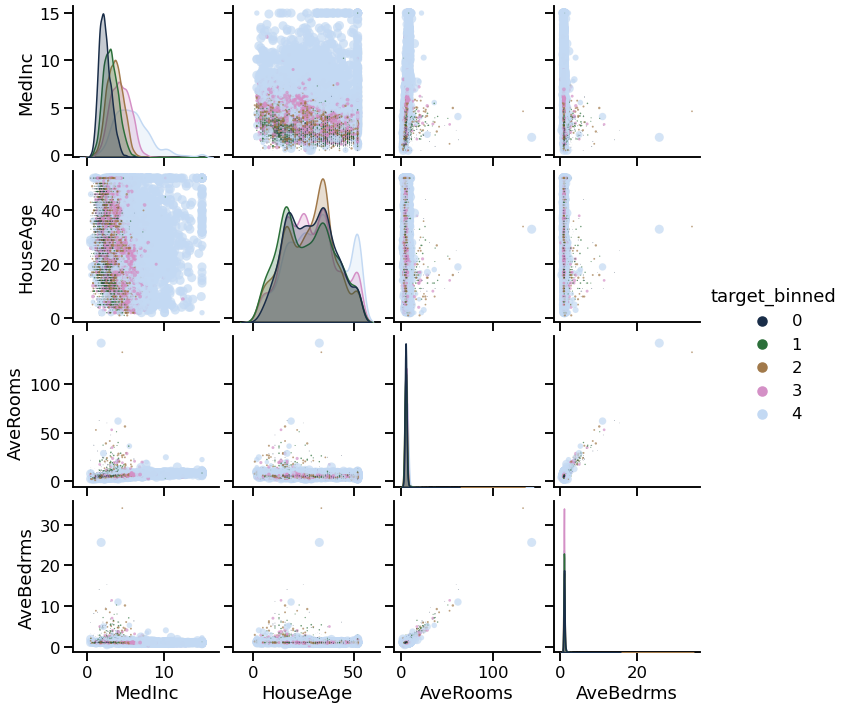

In [8]:
fig = plt.figure(figsize=(7, 7))
point_size = 80*(y/max(y))**3

df1 = df[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', "target_binned"]]
colors = sns.color_palette("colorblind", nbins)

g= sns.pairplot(df1, hue="target_binned", palette=sns.color_palette("cubehelix", nbins),
                         plot_kws=dict(s=point_size, edgecolor=None, alpha=0.7))

### Basic Model Fitting

We need to create a **training set** and a **testing set**.

In [9]:
# half of data
import math
half = math.floor(len(y)/2)
train_X = X[:half]
train_Y = y[:half]
test_X = X[half:]
test_Y = y[half:]

In [10]:
half

10320

## Linear Regression

The following are a set of methods intended for regression in which the target value is expected to be a linear combination of the input variables. In mathematical notion, if $\hat{y}$ is the predicted value.
$$\hat{y}(w, x) = w_0 + w_1 x_1 + ... + w_p x_p$$
Across the module, we designate the vector $w = (w_1,
..., w_p)$ as `coef_` and $w_0$ as `intercept_`.
To perform classification with generalized linear models, see Logistic regression.

http://scikit-learn.org/stable/modules/linear_model.html

In [11]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

clf = linear_model.LinearRegression()

In [12]:
clf?

In [13]:
# fit the model
clf.fit(train_X, train_Y)

LinearRegression()

In [14]:
clf.intercept_

-28.871818045412418

In [15]:
test_X.shape

(10320, 8)

In [16]:
mean_squared_error?

In [17]:
# now do the prediction
Y_lr_pred = clf.predict(test_X)

# how well did we do?
mse = mean_squared_error(test_Y,Y_lr_pred) ; print(mse)

0.5482126919150996


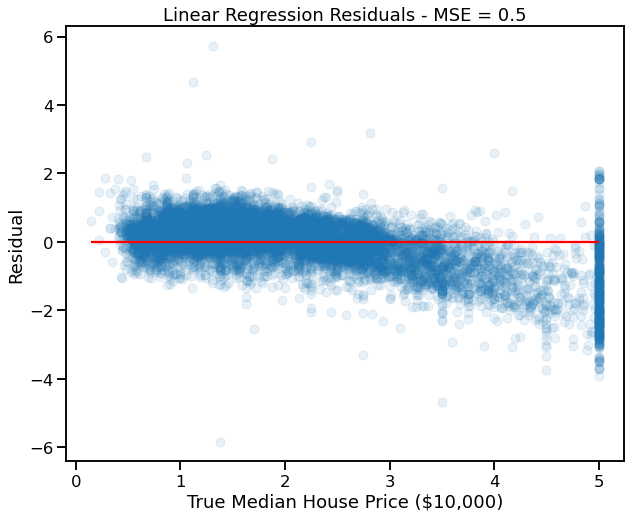

In [18]:
f, ax = plt.subplots(figsize=(10, 8))
ax.plot(test_Y,Y_lr_pred - test_Y, 'o', alpha=0.1)
ax.set_title("Linear Regression Residuals - MSE = %.1f" % mse)
ax.set_xlabel("True Median House Price ($10,000)")
ax.set_ylabel("Residual")
ax.hlines(0,min(test_Y),max(test_Y),color="red")

## *k*-Nearest Neighbor (KNN) Regression

"The principle behind nearest neighbor methods is to find a predefined number of training samples closest in distance to the new point, and predict the label from these. The number of samples can be a user-defined constant (k-nearest neighbor learning), or vary based on the local density of points (radius-based neighbor learning). The distance can, in general, be any metric measure: standard Euclidean distance is the most common choice. Neighbors-based methods are known as non-generalizing machine learning methods, since they simply “remember” all of its training data (possibly transformed into a fast indexing structure such as a Ball Tree or KD Tree.)."

<img src="http://scikit-learn.org/stable/_images/sphx_glr_plot_regression_001.png">

http://scikit-learn.org/stable/modules/neighbors.html

In [ ]:
from sklearn import neighbors
from sklearn import preprocessing

# many methods work better on scaled X
scaler = preprocessing.PowerTransformer() 
X_scaled = scaler.fit_transform(X)

clf1 = neighbors.KNeighborsRegressor(5)

# scale
train_X = X_scaled[:half]
test_X = X_scaled[half:]

# not scaled
#train_X = X[:half]
#test_X = X[half:]


clf1.fit(train_X,train_Y)

In [ ]:
Y_knn_pred = clf1.predict(test_X)
mse = mean_squared_error(test_Y,Y_knn_pred) ; print(mse)

f, ax = plt.subplots(figsize=(10, 8))
ax.plot(test_Y, Y_knn_pred - test_Y, 'o', alpha=0.2)
ax.set_title("k-NN Residuals - MSE = %.1f" % mse)
ax.set_xlabel("True Median House Price ($1,000)")
ax.set_ylabel("Residual")
ax.hlines(0,min(test_Y),max(test_Y),color="red")

Let's see what other datasets are readily available...

In [ ]:
datasets.

## Error Estimation & Model Selection

**Q**: How will our model perform on future data?

So far, we’ve split the data, using one set to train the model and the other to test its performance

This train-test strategy avoids over-fitting to the sample on hand, but wastes data & can produce poor error estimates.

cf. https://scikit-learn.org/stable/modules/cross_validation.html

### model selection: cross-validation


- *K-fold CV* - randomly split the training data into K "folds."  For each $k=1,...,K$, train model only on the data not in fold $k$ & predict for data in fold $k$.  Compute performance metric over CV predictions.

- *Leave-one-out (LOO) CV* -- n-fold CV with  n = number of training points.


<img src="https://www.evernote.com/l/AUWvg9caKz1OO7opS2Ji3Z7OwOFkLCrg2WsB/image.png">

<img src="http://i.stack.imgur.com/YWgro.gif">

In [ ]:
from sklearn import model_selection

In [ ]:
import numpy as np
from sklearn import datasets

from sklearn import linear_model
clf = linear_model.LinearRegression()

from sklearn.model_selection import cross_val_score, cross_val_predict

def print_cv_score_summary(model, xx, yy, cv, verbose=False):
    scores = cross_val_score(model, xx, yy, cv=cv, n_jobs=1, verbose=verbose)
    print("mean: {:3f}, stdev: {:3f}".format(
        np.mean(scores), np.std(scores)))

In [ ]:
# Returns the coefficient of determination R^2 of the prediction.
print_cv_score_summary(clf, X, y,
                       cv=model_selection.KFold(10, shuffle=True, random_state = 42), verbose=True)

In [ ]:
predictions = cross_val_predict(clf, X, y, cv=model_selection.KFold(10, shuffle=True, random_state = 42), n_jobs=1)

In [ ]:
predictions

In [ ]:
mse = mean_squared_error(y, predictions) ; print(mse)

f, ax = plt.subplots(figsize=(10,6))
ax.scatter(y, predictions - y,alpha=0.2,edgecolors=None)
ax.set_title("CV kfold linear model - MSE = %.1f" % mse)
ax.set_xlabel("True log normalized Median House Price")
ax.set_ylabel("Residual")
ax.hlines(0,min(test_Y),max(test_Y),color="red")
ax.set_xlim(0,5.1)

In [ ]:
clf_knn = neighbors.KNeighborsRegressor(15)
print_cv_score_summary(clf_knn, X, y,
                       cv=model_selection.KFold(5, shuffle=True, random_state = 42), verbose=True)

In [ ]:
model_selection.GridSearchCV?

In [ ]:
neighbors.KNeighborsRegressor?

In [ ]:
parameters = {"n_neighbors": [5, 8, 10, 12, 15, 20],  "weights": ["uniform", "distance"]}

knn_tune = model_selection.GridSearchCV(clf_knn, parameters, 
                                   n_jobs = -1, cv = 10, verbose=True, scoring='neg_mean_squared_error')

knn_opt = knn_tune.fit(X, y)

In [ ]:
knn_opt.best_estimator_

# Breakout #1

Common pitfalls: https://scikit-learn.org/stable/common_pitfalls.html#common-pitfalls